<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/main_electricity_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv("NEA_monthly_elec_data.csv")
print(df1.columns.tolist())

['energy_req', 'Date', 'energy_prod']


#GENERATION

In [4]:
df = df1[["Date", "energy_prod"]]
df=df[0:-3]
df

,Date,energy_prod
0,08-01-2018,505040
1,09-01-2018,490230
2,10-01-2018,520850
3,11-01-2018,445860
4,12-01-2018,341960
...,...,...
60,08-01-2023,1457982
61,09-01-2023,1449609
62,10-01-2023,1455851
63,11-01-2023,1185130


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

,energy_prod
Date,
2018-08-01,505040
2018-09-01,490230
2018-10-01,520850
2018-11-01,445860
2018-12-01,341960


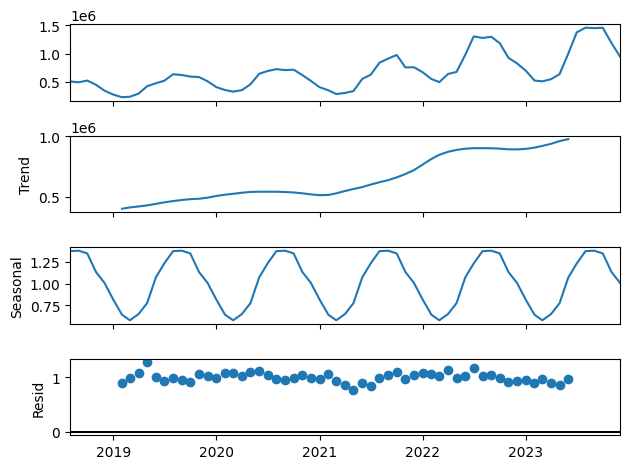

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(1, 1, 1), seasonal_order=(2, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -7.095899e-01
ma.L1       5.636342e-01
ar.S.L12   -8.810964e-01
ar.S.L24   -7.277133e-03
ma.S.L12    8.276540e-01
sigma2      3.181380e+07
dtype: float64


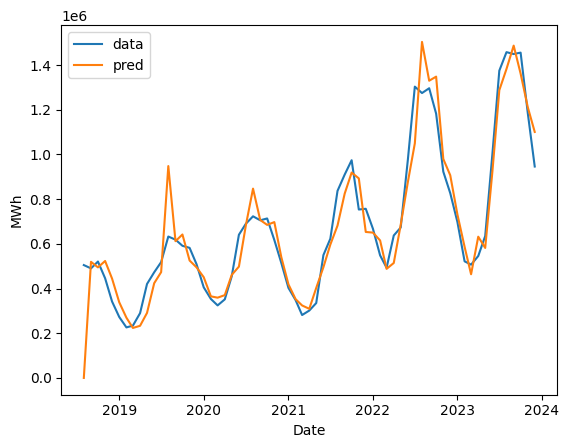

In [8]:
from sklearn.metrics import mean_squared_error
pred_train = model_fit.predict(df.index.min(), df.index.max())
plt.plot(df, label="data")
plt.plot(pred_train, label="pred")
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()

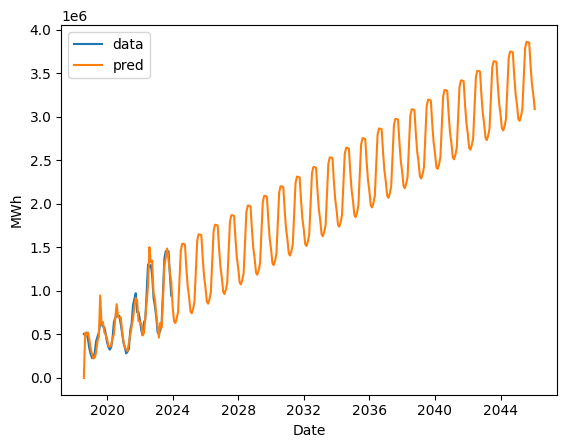

In [9]:
pred_train_gen = model_fit.predict(0, 330)
plt.plot(df, label="data")
plt.plot(pred_train_gen, label="pred")
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()

#DEMAND

In [10]:
df = df1[["Date", "energy_req"]]
df=df[0:-3]

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

,energy_req
Date,
2018-08-01,691470
2018-09-01,678930
2018-10-01,687390
2018-11-01,533140
2018-12-01,529840


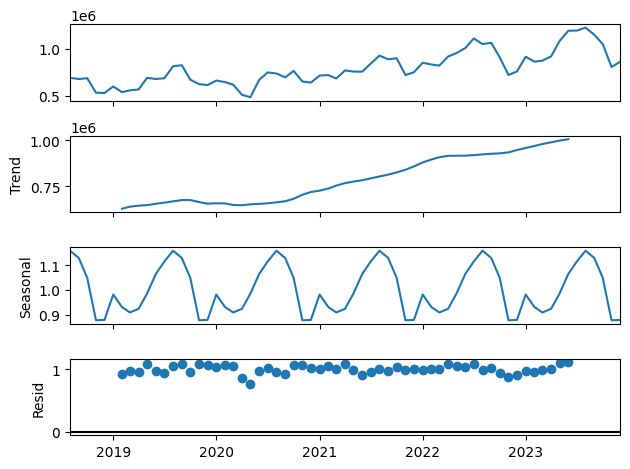

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(1, 1, 1), seasonal_order=(1, 1, 2, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -7.095979e-01
ma.L1       5.636290e-01
ar.S.L12   -8.726824e-01
ma.S.L12    8.192318e-01
ma.S.L24   -6.872326e-03
sigma2      3.181379e+07
dtype: float64


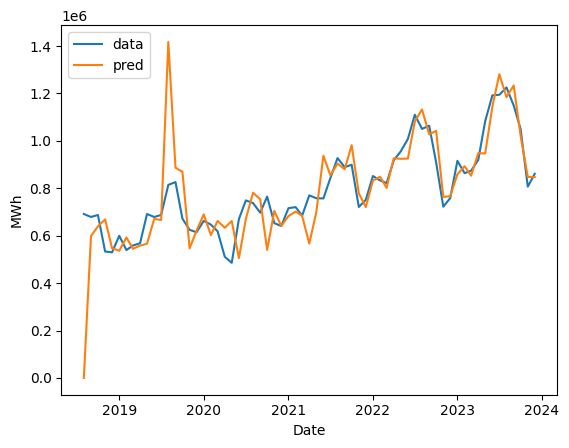

In [14]:
from sklearn.metrics import mean_squared_error
pred_train = model_fit.predict(df.index.min(), df.index.max())
plt.plot(df, label="data")
plt.plot(pred_train, label="pred")
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()

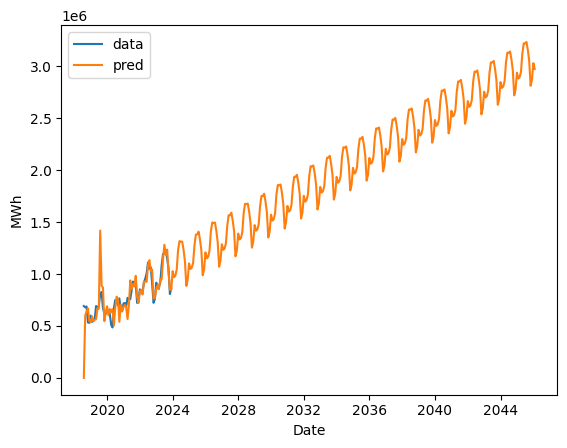

In [15]:
pred_train_dem = model_fit.predict(0, 330)
plt.plot(df, label="data")
plt.plot(pred_train_dem, label="pred")
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()

# NEW


In [29]:
# Assuming 'montly_energy_deficit' is a pandas Series with a DateTimeIndex
start_date = '2024-01-01'
end_date = '2044-12-31'
montly_energy_generation_2024_2044 = pred_train_gen[start_date:end_date]
montly_energy_demand_2024_2044 = pred_train_dem[start_date:end_date]
print(montly_energy_generation_2024_2044.sum())#553104227.6206703
print(montly_energy_demand_2024_2044.sum())#509621852.6680079
print(montly_energy_generation_2024_2044.sum()-montly_energy_demand_2024_2044.sum())#43482374.95266241

553104227.6206703
509621852.6680079
43482374.95266241


In [31]:
import pandas as pd

# Assuming 'df' is your pandas Series with monthly data from 2024 to 2043
# and its index is a DateTimeIndex

# Convert the index to datetime if it's not already
df.index = pd.to_datetime(df.index)

# Group data by year and find the maximum and minimum values
yearly_data = df.groupby(df.index.year)
for year, data in yearly_data:
    max_value = data.max()
    min_value = data.min()
    max_idx = data.idxmax()
    min_idx = data.idxmin()
    max_month = data.idxmax().strftime('%B')  # Get month name
    min_month = data.idxmin().strftime('%B')  # Get month name
    print(f"Year: {year}")
    print(f"  Deficit(MWh): {max_value:.2f}, Gen(MWh):{montly_energy_generation_2024_2044[max_idx]:.2f}, Dem(MWh):{montly_energy_demand_2024_2044[max_idx]:.2f} (Month: {max_month})")
    print(f"  Surplus(MWh): {-min_value:.2f}, Gen(MWh):{montly_energy_generation_2024_2044[min_idx]:.2f}, Dem(MWh):{montly_energy_demand_2024_2044[min_idx]:.2f} (Month: {min_month})")

Year: 2024
  Deficit(MWh): 466624.71, Gen(MWh):762272.41, Dem(MWh):1228897.12 (Month: May)
  Surplus(MWh): 414430.53, Gen(MWh):1534114.93, Dem(MWh):1119684.41 (Month: October)
Year: 2025
  Deficit(MWh): 397993.07, Gen(MWh):874821.44, Dem(MWh):1272814.51 (Month: May)
  Surplus(MWh): 411104.94, Gen(MWh):1641009.99, Dem(MWh):1229905.05 (Month: October)
Year: 2026
  Deficit(MWh): 419923.62, Gen(MWh):985676.32, Dem(MWh):1405599.94 (Month: May)
  Surplus(MWh): 446438.63, Gen(MWh):1751211.87, Dem(MWh):1304773.23 (Month: October)
Year: 2027
  Deficit(MWh): 364421.78, Gen(MWh):1096335.54, Dem(MWh):1460757.32 (Month: May)
  Surplus(MWh): 451273.16, Gen(MWh):1861795.67, Dem(MWh):1410522.51 (Month: October)
Year: 2028
  Deficit(MWh): 376752.24, Gen(MWh):1206972.16, Dem(MWh):1583724.39 (Month: May)
  Surplus(MWh): 483127.05, Gen(MWh):1972423.57, Dem(MWh):1489296.52 (Month: October)
Year: 2029
  Deficit(MWh): 329852.15, Gen(MWh):1317606.16, Dem(MWh):1647458.31 (Month: May)
  Surplus(MWh): 491422.60,

In [40]:
# Assuming you have four lists representing daily energy demand profiles:
#DEMAND_profile
summer_profile = np.array([2.969824,2.872609,2.826801,2.737096,2.789618,5.66768,6.085824,6.347022,3.198262,3.217498,3.273542,3.252386,3.26534,3.270165,3.198414,3.242048,3.210466,6.29616,6.718419,8.184118,7.904825,3.27525,3.152882,3.043749])  # Replace with actual data
summer_profile = np.round(summer_profile, decimals=2)
summer_profile = summer_profile/summer_profile.sum(axis=0, keepdims=1)
winter_profile = np.array([2.336544,2.320511,2.30501,2.32204,2.462131,5.560014,6.539117,7.252489,3.477821,3.305852,3.238413,3.083761,3.012582,3.000048,3.034858,3.109863,3.195698,8.069137,9.136865,8.562146,6.801527,2.830218,2.574986,2.468366])
winter_profile = np.round(winter_profile, decimals=2)
winter_profile = winter_profile/winter_profile.sum(axis=0, keepdims=1)
autumn_profile = np.array([2.805108,2.766741,2.739979,2.718226,2.80585,5.823761,6.069712,6.35323,3.128277,3.115989,3.131347,3.093678,3.113849,3.069111,3.035003,3.112577,3.131837,6.880415,8.30952,8.435532,7.338991,3.113798,3.001501,2.905966])
autumn_profile = np.round(autumn_profile, decimals=2)
autumn_profile = autumn_profile/autumn_profile.sum(axis=0, keepdims=1)
spring_profile = np.array([2.572226,2.516495,2.506694,2.477545,2.568427,5.577822,6.431164,6.924209,3.345391,3.262899,3.241241,3.182685,3.077669,3.158977,3.11433,3.152611,3.010821,6.532548,8.286086,8.651778,7.866901,3.034038,2.792543,2.714898])
spring_profile = np.round(spring_profile, decimals=2)
spring_profile = spring_profile/spring_profile.sum(axis=0, keepdims=1)

# Map months to seasons
season_map = {
    1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn',
    11: 'autumn', 12: 'winter'
}

hourly_energy_deficit = []
hourly_timestamps = []  # To store hourly timestamps


# Demand in hourly
values_demand = []
for date, demand in montly_energy_demand_2024_2044.items():
    # print(date)
    month = date.month
    season = season_map[month]
    num_days_in_month = date.days_in_month
    if num_days_in_month == 29:
      # print(date)
      num_days_in_month = 28

    if season == 'summer':
        daily_profile = summer_profile
    elif season == 'winter':
        daily_profile = winter_profile
    elif season == 'autumn':
        daily_profile = autumn_profile
    else:  # spring
        daily_profile = spring_profile

    # Distribute monthly deficit evenly across days
    daily_demand = demand / num_days_in_month

    # Create hourly data for each day
    hourly_demand = daily_demand*np.array(daily_profile)
    # print(hourly_deficit)

    for i in range(num_days_in_month):
        for j in range(24):
            values_demand.append(hourly_demand[j])
print(len(values_demand))
np.array(values_demand).sum()

183960


509621852.6680079

In [41]:
# Assuming you have four lists representing daily energy demand profiles:
#DEMAND_profile
summer_profile = np.array([2.969824,2.872609,2.826801,2.737096,2.789618,5.66768,6.085824,6.347022,3.198262,3.217498,3.273542,3.252386,3.26534,3.270165,3.198414,3.242048,3.210466,6.29616,6.718419,8.184118,7.904825,3.27525,3.152882,3.043749])  # Replace with actual data
summer_profile = np.round(summer_profile, decimals=2)
summer_profile = summer_profile/summer_profile.sum(axis=0, keepdims=1)
winter_profile = np.array([2.336544,2.320511,2.30501,2.32204,2.462131,5.560014,6.539117,7.252489,3.477821,3.305852,3.238413,3.083761,3.012582,3.000048,3.034858,3.109863,3.195698,8.069137,9.136865,8.562146,6.801527,2.830218,2.574986,2.468366])
winter_profile = np.round(winter_profile, decimals=2)
winter_profile = winter_profile/winter_profile.sum(axis=0, keepdims=1)
autumn_profile = np.array([2.805108,2.766741,2.739979,2.718226,2.80585,5.823761,6.069712,6.35323,3.128277,3.115989,3.131347,3.093678,3.113849,3.069111,3.035003,3.112577,3.131837,6.880415,8.30952,8.435532,7.338991,3.113798,3.001501,2.905966])
autumn_profile = np.round(autumn_profile, decimals=2)
autumn_profile = autumn_profile/autumn_profile.sum(axis=0, keepdims=1)
spring_profile = np.array([2.572226,2.516495,2.506694,2.477545,2.568427,5.577822,6.431164,6.924209,3.345391,3.262899,3.241241,3.182685,3.077669,3.158977,3.11433,3.152611,3.010821,6.532548,8.286086,8.651778,7.866901,3.034038,2.792543,2.714898])
spring_profile = np.round(spring_profile, decimals=2)
spring_profile = spring_profile/spring_profile.sum(axis=0, keepdims=1)

# Map months to seasons
season_map = {
    1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn',
    11: 'autumn', 12: 'winter'
}

hourly_energy_deficit = []
hourly_timestamps = []  # To store hourly timestamps


# Demand in hourly
values_generation = []
for date, generation in montly_energy_generation_2024_2044.items():
    # print(date)
    month = date.month
    season = season_map[month]
    num_days_in_month = date.days_in_month
    if num_days_in_month == 29:
      # print(date)
      num_days_in_month = 28

    if season == 'summer':
        daily_profile = summer_profile
    elif season == 'winter':
        daily_profile = winter_profile
    elif season == 'autumn':
        daily_profile = autumn_profile
    else:  # spring
        daily_profile = spring_profile

    # Distribute monthly deficit evenly across days
    daily_generation = generation / num_days_in_month

    # Create hourly data for each day
    hourly_generation = daily_generation*np.array(daily_profile)
    # print(hourly_deficit)

    for i in range(num_days_in_month):
        for j in range(24):
            values_generation.append(hourly_generation[j])
print(len(values_generation))
np.array(values_generation).sum()

183960


553104227.6206703

In [34]:
# val = 100/24
# flat_profile = np.ones(24)*val
# # Map months to seasons
# season_map = {
#     1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring',
#     6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn',
#     11: 'autumn', 12: 'winter'
# }

# hourly_energy_deficit = []
# hourly_timestamps = []  # To store hourly timestamps


# # Generation in hourly
# values_generation = []
# for date, generation in montly_energy_generation_2024_2044.items():
#     # print(date)
#     month = date.month
#     season = season_map[month]
#     num_days_in_month = date.days_in_month
#     if num_days_in_month == 29:
#       # print(date)
#       num_days_in_month = 28

#     # Distribute monthly generation evenly across days
#     daily_generation = generation / num_days_in_month

#     # Create hourly data for each day
#     hourly_generation = daily_generation*np.array(flat_profile)/100
#     # print(hourly_deficit)

#     for i in range(num_days_in_month):
#         for j in range(24):
#             values_generation.append(hourly_generation[j])
# print(len(values_generation))
# np.array(values_generation).sum()

183960


553104227.6206703

In [42]:
values_deficit = np.array(values_generation)-np.array(values_demand)
values_deficit = values_deficit.tolist()

In [43]:
solar_data_2024_2044 = pd.read_csv('solar_data_2024_2044.csv')
solar_data_2024_2044['deficit_energy'] = values_deficit
solar_data_2024_2044.to_csv('HOURLY_DATA.csv')

In [44]:
# Calculate mean
mean_deficit = solar_data_2024_2044['deficit_energy'].mean()

# Calculate maximum value
max_deficit = solar_data_2024_2044['deficit_energy'].max()

# Calculate minimum value
min_deficit = solar_data_2024_2044['deficit_energy'].min()

# Calculate sum
sum_deficit = solar_data_2024_2044['deficit_energy'].sum()

# Print the results
print("Mean deficit:", mean_deficit)
print("Max deficit:", max_deficit)
print("Min deficit:", min_deficit)
print("Total deficit:", sum_deficit)

Mean deficit: 236.3686396643964
Max deficit: 2140.978786505245
Min deficit: -1302.1636866009544
Total deficit: 43482374.95266236


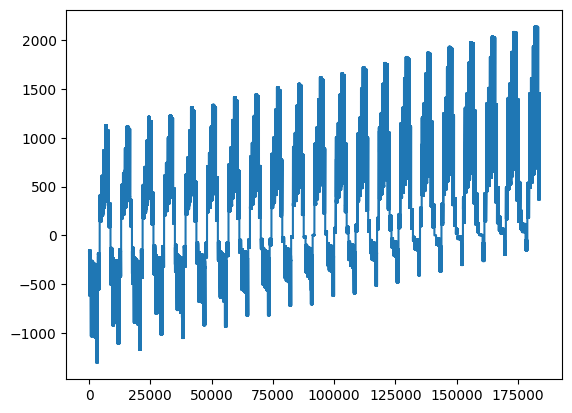

In [45]:
plt.plot(solar_data_2024_2044['deficit_energy'])

In [46]:
solar_data_2024_2044['deficit_energy'].sum()

43482374.95266236

In [47]:
# solar_data_2024_2044 = pd.read_csv('solar_data_2024_2044.csv')
# solar_data_2024_2044['deficit_energy'] = values
solar_data_2024_2044.to_csv('HOURLY_DATA.csv')

#DEFICIT

In [48]:
montly_energy_deficit=pred_train_gen-pred_train_dem
montly_energy_deficit

,predicted_mean
2018-08-01,0.000000
2018-09-01,-78809.648748
2018-10-01,-144778.367638
2018-11-01,-145416.861753
2018-12-01,-102571.347508
...,...
2045-10-01,804477.187498
2045-11-01,778270.212663
2045-12-01,512799.916729
2046-01-01,224702.153836


In [49]:
montly_energy_deficit.sum()

40838841.07748754

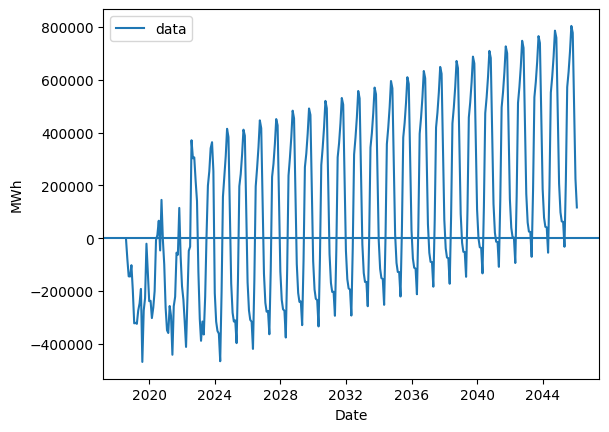

In [ ]:
plt.plot(montly_energy_deficit, label="data")
plt.axhline(y=0)
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()

In [ ]:
# Assuming 'montly_energy_deficit' is a pandas Series with a DateTimeIndex
start_date = '2024-01-01'
end_date = '2044-12-31'
montly_energy_deficit_2024_2044 = montly_energy_deficit[start_date:end_date]
# print(montly_energy_deficit_2024_2044)
montly_energy_deficit_2024_2044.sum()
# montly_energy_deficit_2024_2044

43482374.95266236

# Load profile for various season

In [ ]:
# Assuming 'montly_energy_deficit_2024_2044' is a pandas Series with a DateTimeIndex
start_date = '2024-01-01'
end_date = '2044-12-31'
montly_energy_deficit_2024_2044 = montly_energy_deficit[start_date:end_date]

# Assuming you have four lists representing daily energy demand profiles:
summer_profile = [2.969824,2.872609,2.826801,2.737096,2.789618,5.66768,6.085824,6.347022,3.198262,3.217498,3.273542,3.252386,3.26534,3.270165,3.198414,3.242048,3.210466,6.29616,6.718419,8.184118,7.904825,3.27525,3.152882,3.043749]  # Replace with actual data
winter_profile = [2.336544,2.320511,2.30501,2.32204,2.462131,5.560014,6.539117,7.252489,3.477821,3.305852,3.238413,3.083761,3.012582,3.000048,3.034858,3.109863,3.195698,8.069137,9.136865,8.562146,6.801527,2.830218,2.574986,2.468366]
autumn_profile = [2.805108,2.766741,2.739979,2.718226,2.80585,5.823761,6.069712,6.35323,3.128277,3.115989,3.131347,3.093678,3.113849,3.069111,3.035003,3.112577,3.131837,6.880415,8.30952,8.435532,7.338991,3.113798,3.001501,2.905966]
spring_profile = [2.572226,2.516495,2.506694,2.477545,2.568427,5.577822,6.431164,6.924209,3.345391,3.262899,3.241241,3.182685,3.077669,3.158977,3.11433,3.152611,3.010821,6.532548,8.286086,8.651778,7.866901,3.034038,2.792543,2.714898]

# Map months to seasons
season_map = {
    1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn',
    11: 'autumn', 12: 'winter'
}

hourly_energy_deficit = []
hourly_timestamps = []  # To store hourly timestamps

values = []
for date, deficit in montly_energy_deficit_2024_2044.items():
    # print(date)
    month = date.month
    season = season_map[month]
    num_days_in_month = date.days_in_month
    if num_days_in_month == 29:
      # print(date)
      num_days_in_month = 28

    if season == 'summer':
        daily_profile = summer_profile
    elif season == 'winter':
        daily_profile = winter_profile
    elif season == 'autumn':
        daily_profile = autumn_profile
    else:  # spring
        daily_profile = spring_profile

    # Distribute monthly deficit evenly across days
    daily_deficit = deficit / num_days_in_month

    # Create hourly data for each day
    hourly_deficit = daily_deficit*np.array(daily_profile)/100
    # print(hourly_deficit)

    for i in range(num_days_in_month):
        for j in range(24):
            values.append(hourly_deficit[j])
# print(len(values))

In [ ]:
solar_data_2024_2044 = pd.read_csv('solar_data_2024_2044.csv')
solar_data_2024_2044['deficit_energy'] = values
solar_data_2024_2044.to_csv('HOURLY_DATA.csv')

In [ ]:
# Calculate mean
mean_deficit = solar_data_2024_2044['deficit_energy'].mean()

# Calculate maximum value
max_deficit = solar_data_2024_2044['deficit_energy'].max()

# Calculate minimum value
min_deficit = solar_data_2024_2044['deficit_energy'].min()

# Calculate sum
sum_deficit = solar_data_2024_2044['deficit_energy'].sum()

# Print the results
print("Mean deficit:", mean_deficit)
print("Max deficit:", max_deficit)
print("Min deficit:", min_deficit)
print("Total deficit:", sum_deficit)

Mean deficit: 236.36863473211
Max deficit: 2140.0593713735375
Min deficit: -1302.30110208317
Total deficit: 43482374.04531895


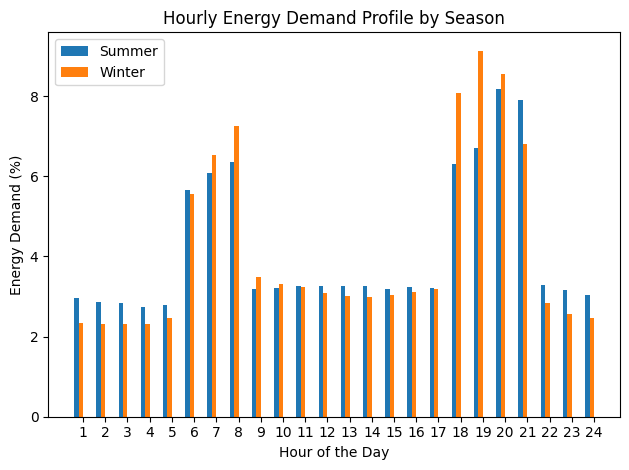

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Data for the bar graph
seasons = ['Summer', 'Winter', 'Autumn', 'Spring']
summer_profile = [2.969824,2.872609,2.826801,2.737096,2.789618,5.66768,6.085824,6.347022,3.198262,3.217498,3.273542,3.252386,3.26534,3.270165,3.198414,3.242048,3.210466,6.29616,6.718419,8.184118,7.904825,3.27525,3.152882,3.043749]
winter_profile = [2.336544,2.320511,2.30501,2.32204,2.462131,5.560014,6.539117,7.252489,3.477821,3.305852,3.238413,3.083761,3.012582,3.000048,3.034858,3.109863,3.195698,8.069137,9.136865,8.562146,6.801527,2.830218,2.574986,2.468366]
autumn_profile = [2.805108,2.766741,2.739979,2.718226,2.80585,5.823761,6.069712,6.35323,3.128277,3.115989,3.131347,3.093678,3.113849,3.069111,3.035003,3.112577,3.131837,6.880415,8.30952,8.435532,7.338991,3.113798,3.001501,2.905966]
spring_profile = [2.572226,2.516495,2.506694,2.477545,2.568427,5.577822,6.431164,6.924209,3.345391,3.262899,3.241241,3.182685,3.077669,3.158977,3.11433,3.152611,3.010821,6.532548,8.286086,8.651778,7.866901,3.034038,2.792543,2.714898]

# Setting the positions of bars on X-axis
bar_width = 0.2
index = np.arange(24)

# Plotting the bars
plt.bar(index, summer_profile, width=bar_width, label='Summer')
plt.bar(index + bar_width, winter_profile, width=bar_width, label='Winter')
# plt.bar(index + 2 * bar_width, autumn_profile, width=bar_width, label='Autumn')
# plt.bar(index + 3 * bar_width, spring_profile, width=bar_width, label='Spring')

# Adding labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Demand (%)')
plt.title('Hourly Energy Demand Profile by Season')
plt.xticks(index + 1.5 * bar_width, range(1, 25))  # Set x-axis labels to represent hours
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


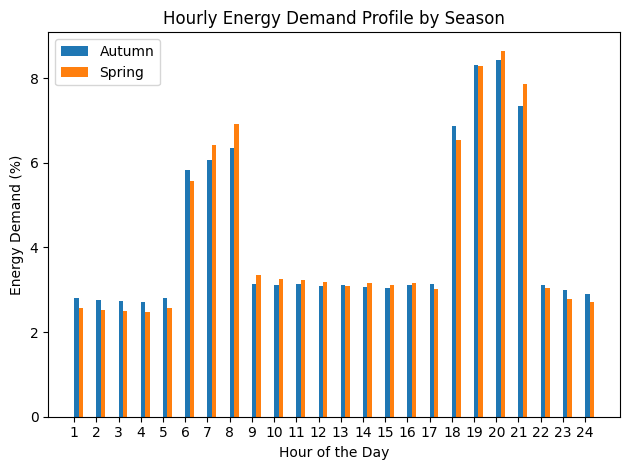

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Data for the bar graph
seasons = ['Summer', 'Winter', 'Autumn', 'Spring']
summer_profile = [2.969824,2.872609,2.826801,2.737096,2.789618,5.66768,6.085824,6.347022,3.198262,3.217498,3.273542,3.252386,3.26534,3.270165,3.198414,3.242048,3.210466,6.29616,6.718419,8.184118,7.904825,3.27525,3.152882,3.043749]
winter_profile = [2.336544,2.320511,2.30501,2.32204,2.462131,5.560014,6.539117,7.252489,3.477821,3.305852,3.238413,3.083761,3.012582,3.000048,3.034858,3.109863,3.195698,8.069137,9.136865,8.562146,6.801527,2.830218,2.574986,2.468366]
autumn_profile = [2.805108,2.766741,2.739979,2.718226,2.80585,5.823761,6.069712,6.35323,3.128277,3.115989,3.131347,3.093678,3.113849,3.069111,3.035003,3.112577,3.131837,6.880415,8.30952,8.435532,7.338991,3.113798,3.001501,2.905966]
spring_profile = [2.572226,2.516495,2.506694,2.477545,2.568427,5.577822,6.431164,6.924209,3.345391,3.262899,3.241241,3.182685,3.077669,3.158977,3.11433,3.152611,3.010821,6.532548,8.286086,8.651778,7.866901,3.034038,2.792543,2.714898]

# Setting the positions of bars on X-axis
bar_width = 0.2
index = np.arange(24)

# Plotting the bars
# plt.bar(index, summer_profile, width=bar_width, label='Summer')
# plt.bar(index + bar_width, winter_profile, width=bar_width, label='Winter')
plt.bar(index + 2 * bar_width, autumn_profile, width=bar_width, label='Autumn')
plt.bar(index + 3 * bar_width, spring_profile, width=bar_width, label='Spring')

# Adding labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Demand (%)')
plt.title('Hourly Energy Demand Profile by Season')
plt.xticks(index + 1.5 * bar_width, range(1, 25))  # Set x-axis labels to represent hours
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

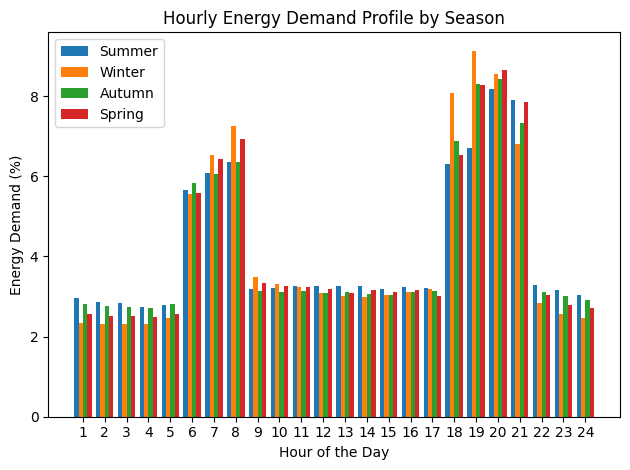

In [ ]:
# prompt: draw the demand profile in bar graph for the 24 hour data for the four season

import matplotlib.pyplot as plt
import numpy as np
# Data for the bar graph
seasons = ['Summer', 'Winter', 'Autumn', 'Spring']
summer_profile = [2.969824,2.872609,2.826801,2.737096,2.789618,5.66768,6.085824,6.347022,3.198262,3.217498,3.273542,3.252386,3.26534,3.270165,3.198414,3.242048,3.210466,6.29616,6.718419,8.184118,7.904825,3.27525,3.152882,3.043749]
winter_profile = [2.336544,2.320511,2.30501,2.32204,2.462131,5.560014,6.539117,7.252489,3.477821,3.305852,3.238413,3.083761,3.012582,3.000048,3.034858,3.109863,3.195698,8.069137,9.136865,8.562146,6.801527,2.830218,2.574986,2.468366]
autumn_profile = [2.805108,2.766741,2.739979,2.718226,2.80585,5.823761,6.069712,6.35323,3.128277,3.115989,3.131347,3.093678,3.113849,3.069111,3.035003,3.112577,3.131837,6.880415,8.30952,8.435532,7.338991,3.113798,3.001501,2.905966]
spring_profile = [2.572226,2.516495,2.506694,2.477545,2.568427,5.577822,6.431164,6.924209,3.345391,3.262899,3.241241,3.182685,3.077669,3.158977,3.11433,3.152611,3.010821,6.532548,8.286086,8.651778,7.866901,3.034038,2.792543,2.714898]

# Setting the positions of bars on X-axis
bar_width = 0.2
index = np.arange(len(summer_profile))

# Plotting the bars
plt.bar(index, summer_profile, width=bar_width, label='Summer')
plt.bar(index + bar_width, winter_profile, width=bar_width, label='Winter')
plt.bar(index + 2 * bar_width, autumn_profile, width=bar_width, label='Autumn')
plt.bar(index + 3 * bar_width, spring_profile, width=bar_width, label='Spring')

# Adding labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Demand (%)')
plt.title('Hourly Energy Demand Profile by Season')
plt.xticks(index + 1.5 * bar_width, range(1, 25))  # Set x-axis labels to represent hours
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()
